In [92]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models
# from tqdm import tqdm
from pathlib import Path
import imageio
import glob
from itertools import product
from tqdm import tqdm_notebook as tqdm

In [93]:
torch.cuda.set_device(0)

In [94]:
torch.__version__

'0.4.1'

## Load in VGG19 (features)

VGG19 is split into two portions:
* `vgg19.features`, which are all the convolutional and pooling layers
* `vgg19.classifier`, which are the three linear, classifier layers at the end

We only need the `features` portion, which we're going to load in and "freeze" the weights of, below.

In [95]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [96]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
print('Using', "GPU" if torch.cuda.is_available() else "CPU" )

Using GPU


### Load in Content and Style Images

You can load in any images you want! Below, we've provided a helper function for loading in any type and size of image. The `load_image` function also converts images to normalized Tensors.

Additionally, it will be easier to have smaller images and to squish the content and style images so that they are of the same size.

In [97]:
def load_image(img_path, max_size=50, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Next, I'm loading in images by file name and forcing the style image to be the same size as the content image.

In [98]:
CONTENT = Path('content')
STYLE = Path('style')

content_image = 'fire.jpg'
style_images = ['fire.jpg']

content_fn = content_image.split('.')[0]
style_fns = [i.split('.')[0] for i in style_images]

In [99]:
# load in content and style image
content = load_image(CONTENT/content_image).to(device)
# Resize style to match content, makes code easier
styles = [load_image(STYLE/i, shape=content.shape[-2:]).to(device) for i in style_images]

In [100]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [101]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

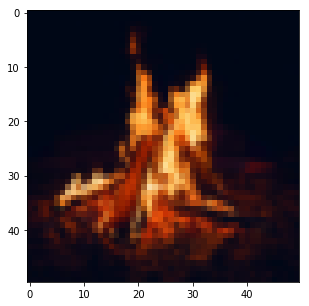

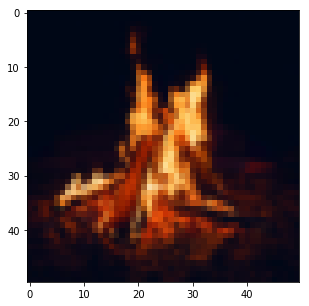

In [102]:
%matplotlib inline
# display the images
fig, ax1,  = plt.subplots(1, 1, figsize=(5, 5))
# content and style ims side-by-side
ax1.imshow(im_convert(content))

if len(styles)> 1:
    fig, axs = plt.subplots(1, len(styles), figsize= (5, 5*len(styles)))
    for ax, style in zip(axs, styles):
        ax.imshow(im_convert(style))
else:
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    ax.imshow(im_convert(styles[0]))

---
## VGG19 Layers

To get the content and style representations of an image, we have to pass an image forward throug the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

In [103]:
# print out VGG16 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

## Content and Style Features

Below, complete the mapping of layer names to the names found in the paper for the _content representation_ and the _style representation_.

In [104]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'
                 }
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

## Putting it all Together

Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [105]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features_ls = [get_features(i, vgg) for i in styles]

# calculate the gram matrices for each layer of our style representation
style_grams_ls = [{layer: gram_matrix(style_features[layer])  for style_features in style_features_ls for layer in style_features}]

# Start with copy of content image
target = content.clone().requires_grad_(True).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


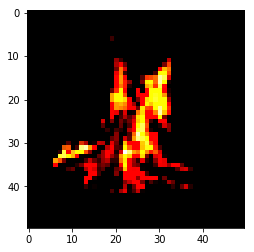

In [106]:
plt.imshow(target[0,:,:,:].detach().cpu().permute((1,2,0)))

In [107]:
# weights for each style layer
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation

style_weights_dict = {

    'High': {'conv1_1': 0.2,
             'conv2_1': 0.2,
             'conv3_1': 0.2,
             'conv4_1': 0.75,
             'conv5_1': 1},
    
    'Normal': {'conv1_1': 1.,
               'conv2_1': 0.75,
               'conv3_1': 0.2,
               'conv4_1': 0.2,
               'conv5_1': 0.2},

    'Low': {'conv1_1': 0.5,
            'conv2_1': 0.3,
            'conv3_1': 0.2,
            'conv4_1': 0.2,
            'conv5_1': 0.2},
    
        'Classic': {'conv1_1': 0.2,
            'conv2_1': 0.2,
            'conv3_1': 0.2,
            'conv4_1': 0.2,
            'conv5_1': 0.2}
}



# content_style_ratio = 1e-6  # alpha/beta ratio


# Visualize style of different style weight

In [108]:
content_features['conv1_1'][:,0,:,:].size()

torch.Size([1, 50, 50])

# New Part

In [109]:
style_levels =  ['Classic','Normal','Low']
style_content_ratios = [100,10000,1000000]

list(product(style_levels, style_content_ratios))

[('Classic', 100),
 ('Classic', 10000),
 ('Classic', 1000000),
 ('Normal', 100),
 ('Normal', 10000),
 ('Normal', 1000000),
 ('Low', 100),
 ('Low', 10000),
 ('Low', 1000000)]

run [20]:
Style Loss: 0.000000 Content Loss: 0.000000
Total Loss: 0.000000

Step 20 -------


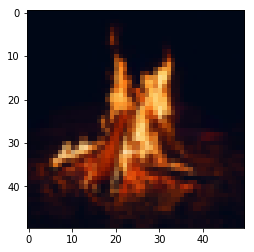

run [20]:
Style Loss: 0.000000 Content Loss: 0.000000
Total Loss: 0.000000

Step 20 -------


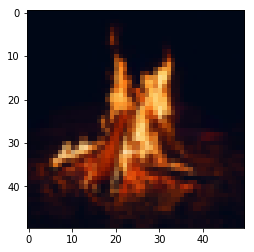

run [20]:
Style Loss: 0.000000 Content Loss: 0.000000
Total Loss: 0.000000

Step 20 -------


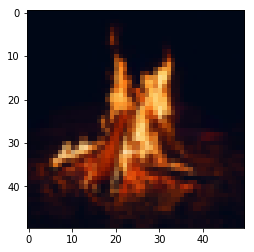

run [20]:
Style Loss: 0.000000 Content Loss: 0.000000
Total Loss: 0.000000

Step 20 -------


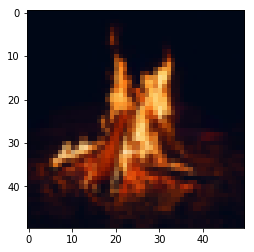

run [20]:
Style Loss: 0.000000 Content Loss: 0.000000
Total Loss: 0.000000

Step 20 -------


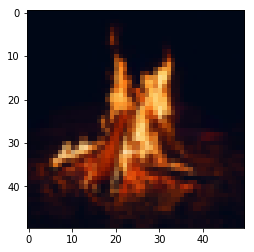

run [20]:
Style Loss: 0.000000 Content Loss: 0.000000
Total Loss: 0.000000

Step 20 -------


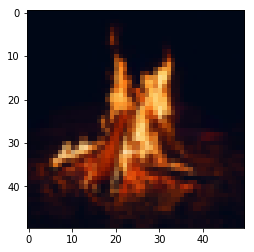

run [20]:
Style Loss: 0.000000 Content Loss: 0.000000
Total Loss: 0.000000

Step 20 -------


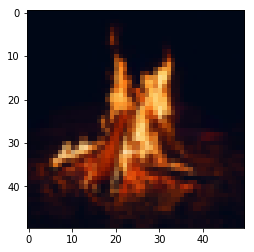

run [20]:
Style Loss: 0.000000 Content Loss: 0.000000
Total Loss: 0.000000

Step 20 -------


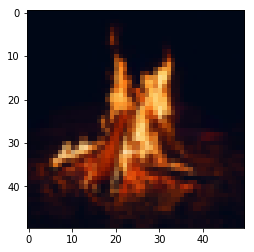

run [20]:
Style Loss: 0.000000 Content Loss: 0.000000
Total Loss: 0.000000

Step 20 -------


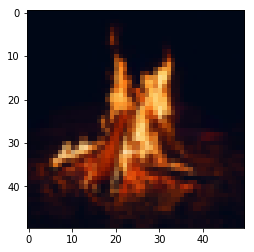

In [110]:
for style_level, style_content_ratio in tqdm(list(product(style_levels,style_content_ratios))):
    # Start from a fresh photo
    target = content.clone().requires_grad_(True).to(device)
           
    # for displaying the target image, intermittently
    show_every = 1
    style_weights = style_weights_dict[style_level]
    # iteration hyperparameters
    optimizer = optim.LBFGS([target], lr=0.2)
    steps = 20  # decide how many iterations to update your image (5000)
    run = [0]

    OUTPUT = Path('output')
    output_dir = f"{content_fn}_{'_'.join([fn for fn in style_fns])}"
    OUTPUT = OUTPUT/output_dir
    OUTPUT.mkdir(exist_ok=True)
    OUTPUT_SUBPATH = OUTPUT/f"{style_level}_{style_content_ratio}"
    OUTPUT_SUBPATH.mkdir(exist_ok=True)

    for ii in tqdm(range(1, steps+1)):

        def closure():
            # get the features from your target image
            target_features = get_features(target, vgg)

            # the content loss
            content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

            # initialize the style loss to 0
            style_loss = 0
            # then add to it for each layer's gram matrix loss
            for layer in style_weights:
                # get the "target" style representation for the layer
                target_feature = target_features[layer]
                target_gram = gram_matrix(target_feature)
                _, d, h, w = target_feature.shape
                for style_grams in style_grams_ls:
                    # get the "style" style representation
                    style_gram = style_grams[layer]
                    # the style loss for one layer, weighted appropriately
                    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
                    # add to the style loss
                    style_loss += layer_style_loss / (d * h * w)

            # calculate the *total* loss
            style_loss =  style_loss * style_content_ratio            
            total_loss =  content_loss  + style_loss

            # update your target image
            optimizer.zero_grad()
            total_loss.backward()

            run[0] += 1
            if run[0] % 20 == 0:
                print("run {}:".format(run))
                print('Style Loss: {:4f}'.format(style_loss), 'Content Loss: {:4f}'.format(content_loss))
                print('Total Loss: {:4f}'.format(total_loss))
                print()
                print(f'Step {ii} -------')
            return total_loss
        
        # Save the first image
        plt.imsave(OUTPUT_SUBPATH/f"{ii}.jpg",im_convert(target))
        optimizer.step(closure)
              
    # Finish 1 set of parameter                  
    images = []
    for filename in OUTPUT_SUBPATH.glob('*.jpg'):
         images.append(imageio.imread(filename))
    
    imageio.mimsave(OUTPUT/f"{output_dir}_{style_level}_{style_content_ratio}.gif", images, fps=4) # Output gif
    plt.imsave(OUTPUT/f"{output_dir}_{style_level}_{style_level}_{style_content_ratio}.jpg",im_convert(target)) # Output the last image as well
    plt.imshow(im_convert(target))
    plt.show()


## Display the Target Image

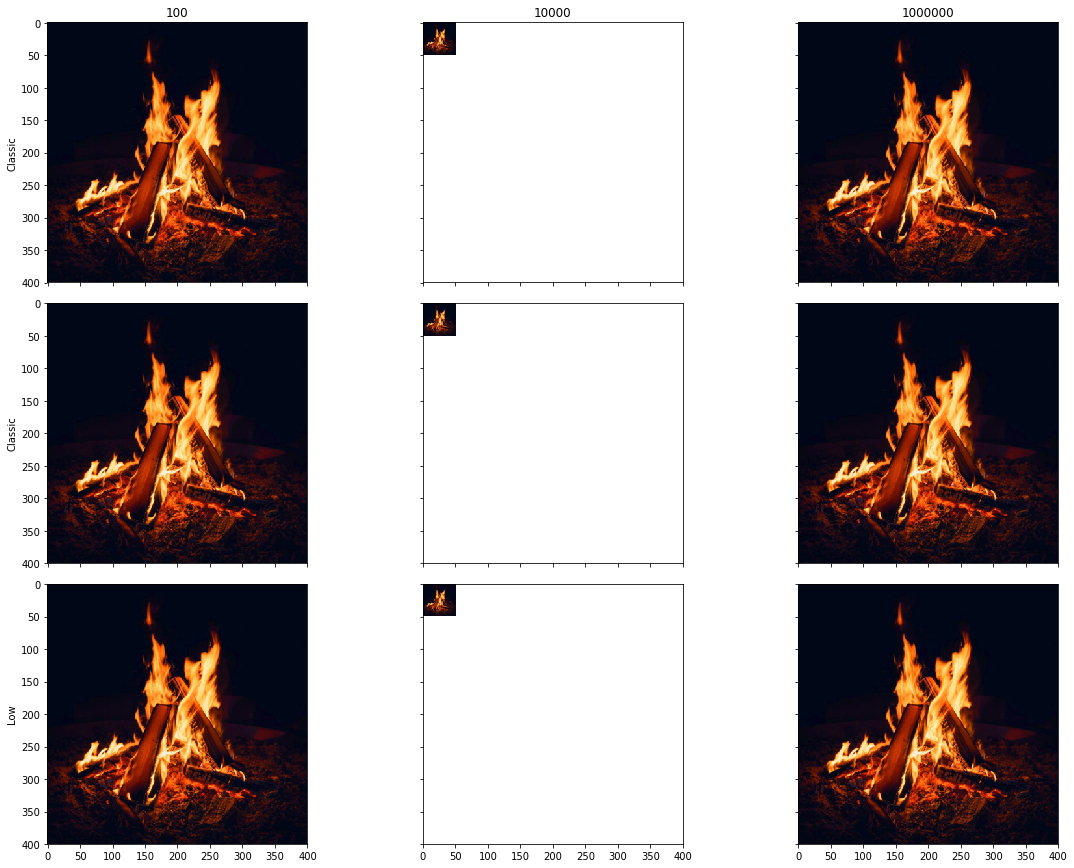

In [111]:
h,w = len(style_content_ratios), len(style_levels)
fig, axs = plt.subplots(h, w, figsize = (16,12), sharex=True, sharey=True)
plt.tight_layout()

imgs = []
styles = []
ratios = []
files = []
for file in OUTPUT.glob('*.jpg'):
    files.append(file)
    img = plt.imread(file)
    imgs.append(img)
    styles.append(file.parts[-1].split('_')[-2])
    ratios.append(file.parts[-1].split('_')[-1].split('.jpg')[0])

for i,ax in enumerate(axs):  
    for j, axe  in enumerate(ax):
        if i==0:
            axe.set_title(ratios[i*len(style_content_ratios) + j])
        if j==0:
            axe.set_ylabel(styles[i*len(style_content_ratios) + j])
        axe.imshow(imgs[j*len(style_content_ratios) + i])
    
plt.show()

In [112]:
fig.savefig(f"{output_dir}.jpg")

# Multiple style Images

In [113]:
style_image_weights = [1, 2]

In [122]:
CONTENT = Path('content')
STYLE = Path('style')

content_image = 'magic.jpg'
style_images = ['fire.jpg', 'picasso.jpg']

content_fn = content_image.split('.')[0]
style_fns = [i.split('.')[0] for i in style_images]

In [123]:
# load in content and style image
content = load_image(CONTENT/content_image).to(device)
# Resize style to match content, makes code easier
styles = [load_image(STYLE/i, shape=content.shape[-2:]).to(device) for i in style_images]

In [124]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features_ls = [get_features(i, vgg) for i in styles]

# calculate the gram matrices for each layer of our style representation
style_grams_ls = [{layer: gram_matrix(style_features[layer])  for style_features in style_features_ls for layer in style_features}]

# Start with copy of content image
target = content.clone().requires_grad_(True).to(device)

run [20]:
Style Loss: 195.206451 Content Loss: 12.580111
Total Loss: 207.786560

Step 1 -------
run [40]:
Style Loss: 40.419064 Content Loss: 14.239865
Total Loss: 54.658928

Step 2 -------
run [60]:
Style Loss: 23.504887 Content Loss: 13.885745
Total Loss: 37.390633

Step 3 -------
run [80]:
Style Loss: 16.801271 Content Loss: 13.848974
Total Loss: 30.650246

Step 4 -------
run [100]:
Style Loss: 13.638899 Content Loss: 13.689747
Total Loss: 27.328646

Step 5 -------
run [120]:
Style Loss: 12.055593 Content Loss: 13.460552
Total Loss: 25.516146

Step 6 -------
run [140]:
Style Loss: 10.902576 Content Loss: 13.521842
Total Loss: 24.424419

Step 7 -------
run [160]:
Style Loss: 10.289083 Content Loss: 13.486760
Total Loss: 23.775845

Step 8 -------
run [180]:
Style Loss: 9.859511 Content Loss: 13.435752
Total Loss: 23.295263

Step 9 -------
run [200]:
Style Loss: 9.581115 Content Loss: 13.352949
Total Loss: 22.934063

Step 10 -------
run [220]:
Style Loss: 9.392825 Content Loss: 13.2738

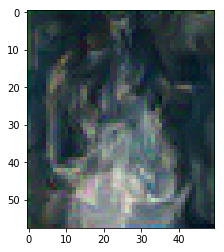

run [20]:
Style Loss: 19841.154297 Content Loss: 14.469623
Total Loss: 19855.623047

Step 1 -------
run [40]:
Style Loss: 3763.131104 Content Loss: 17.745001
Total Loss: 3780.876221

Step 2 -------
run [60]:
Style Loss: 2074.055176 Content Loss: 18.528704
Total Loss: 2092.583984

Step 3 -------
run [80]:
Style Loss: 1434.233398 Content Loss: 18.522917
Total Loss: 1452.756348

Step 4 -------
run [100]:
Style Loss: 1139.898315 Content Loss: 18.706144
Total Loss: 1158.604492

Step 5 -------
run [120]:
Style Loss: 967.856628 Content Loss: 18.767998
Total Loss: 986.624634

Step 6 -------
run [140]:
Style Loss: 861.347839 Content Loss: 18.691914
Total Loss: 880.039734

Step 7 -------
run [160]:
Style Loss: 796.971558 Content Loss: 18.716429
Total Loss: 815.687988

Step 8 -------
run [180]:
Style Loss: 751.283813 Content Loss: 18.681301
Total Loss: 769.965088

Step 9 -------
run [200]:
Style Loss: 712.904785 Content Loss: 18.656559
Total Loss: 731.561340

Step 10 -------
run [220]:
Style Loss

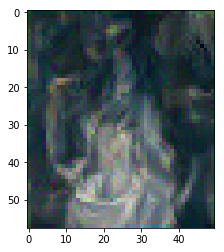

run [20]:
Style Loss: 1962704.875000 Content Loss: 14.562247
Total Loss: 1962719.375000

Step 1 -------
run [40]:
Style Loss: 374444.187500 Content Loss: 17.796801
Total Loss: 374461.968750

Step 2 -------
run [60]:
Style Loss: 207476.843750 Content Loss: 18.372099
Total Loss: 207495.218750

Step 3 -------
run [80]:
Style Loss: 145988.734375 Content Loss: 18.616344
Total Loss: 146007.343750

Step 4 -------
run [100]:
Style Loss: 115979.609375 Content Loss: 18.746771
Total Loss: 115998.359375

Step 5 -------
run [120]:
Style Loss: 98542.656250 Content Loss: 18.733870
Total Loss: 98561.390625

Step 6 -------
run [140]:
Style Loss: 87491.781250 Content Loss: 18.702188
Total Loss: 87510.484375

Step 7 -------
run [160]:
Style Loss: 80057.242188 Content Loss: 18.685196
Total Loss: 80075.929688

Step 8 -------
run [180]:
Style Loss: 74527.781250 Content Loss: 18.674179
Total Loss: 74546.453125

Step 9 -------
run [200]:
Style Loss: 69928.750000 Content Loss: 18.706045
Total Loss: 69947.45312

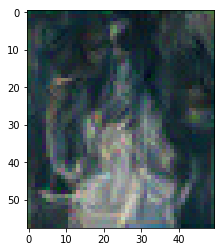

run [20]:
Style Loss: 156.630417 Content Loss: 13.378401
Total Loss: 170.008820

Step 1 -------
run [40]:
Style Loss: 39.914818 Content Loss: 14.856783
Total Loss: 54.771599

Step 2 -------
run [60]:
Style Loss: 21.528234 Content Loss: 14.642145
Total Loss: 36.170380

Step 3 -------
run [80]:
Style Loss: 16.232855 Content Loss: 14.153033
Total Loss: 30.385887

Step 4 -------
run [100]:
Style Loss: 14.355521 Content Loss: 13.955471
Total Loss: 28.310993

Step 5 -------
run [120]:
Style Loss: 13.306507 Content Loss: 13.828160
Total Loss: 27.134666

Step 6 -------
run [140]:
Style Loss: 12.579174 Content Loss: 13.729963
Total Loss: 26.309137

Step 7 -------
run [160]:
Style Loss: 11.947264 Content Loss: 13.710784
Total Loss: 25.658047

Step 8 -------
run [180]:
Style Loss: 11.489669 Content Loss: 13.675866
Total Loss: 25.165535

Step 9 -------
run [200]:
Style Loss: 11.158679 Content Loss: 13.649567
Total Loss: 24.808247

Step 10 -------
run [220]:
Style Loss: 10.924897 Content Loss: 13.6

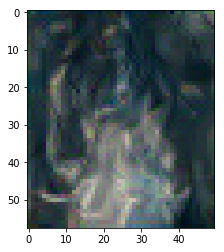

run [20]:
Style Loss: 15271.750977 Content Loss: 15.342826
Total Loss: 15287.093750

Step 1 -------
run [40]:
Style Loss: 3894.937012 Content Loss: 17.892996
Total Loss: 3912.830078

Step 2 -------
run [60]:
Style Loss: 1897.767944 Content Loss: 18.607309
Total Loss: 1916.375244

Step 3 -------
run [80]:
Style Loss: 1368.023804 Content Loss: 18.739567
Total Loss: 1386.763428

Step 4 -------
run [100]:
Style Loss: 1141.799194 Content Loss: 18.822020
Total Loss: 1160.621216

Step 5 -------
run [120]:
Style Loss: 1001.282043 Content Loss: 18.843748
Total Loss: 1020.125793

Step 6 -------
run [140]:
Style Loss: 917.720398 Content Loss: 18.799534
Total Loss: 936.519958

Step 7 -------
run [160]:
Style Loss: 859.682739 Content Loss: 18.798431
Total Loss: 878.481201

Step 8 -------
run [180]:
Style Loss: 816.204529 Content Loss: 18.769943
Total Loss: 834.974487

Step 9 -------
run [200]:
Style Loss: 778.605835 Content Loss: 18.729765
Total Loss: 797.335571

Step 10 -------
run [220]:
Style Lo

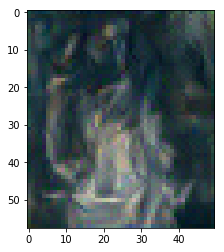

run [20]:
Style Loss: 1540323.500000 Content Loss: 15.529715
Total Loss: 1540339.000000

Step 1 -------
run [40]:
Style Loss: 392890.718750 Content Loss: 17.794846
Total Loss: 392908.500000

Step 2 -------
run [60]:
Style Loss: 194286.296875 Content Loss: 18.589022
Total Loss: 194304.890625

Step 3 -------
run [80]:
Style Loss: 138346.484375 Content Loss: 18.722342
Total Loss: 138365.203125

Step 4 -------
run [100]:
Style Loss: 116163.312500 Content Loss: 18.784605
Total Loss: 116182.093750

Step 5 -------
run [120]:
Style Loss: 103448.687500 Content Loss: 18.868860
Total Loss: 103467.554688

Step 6 -------
run [140]:
Style Loss: 94760.031250 Content Loss: 18.841578
Total Loss: 94778.875000

Step 7 -------
run [160]:
Style Loss: 88706.773438 Content Loss: 18.815500
Total Loss: 88725.585938

Step 8 -------
run [180]:
Style Loss: 83907.429688 Content Loss: 18.828032
Total Loss: 83926.257812

Step 9 -------
run [200]:
Style Loss: 79253.625000 Content Loss: 18.789776
Total Loss: 79272.414

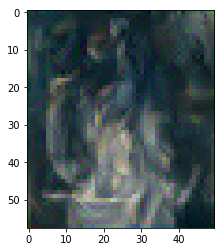

run [20]:
Style Loss: 143.313904 Content Loss: 13.391714
Total Loss: 156.705612

Step 1 -------
run [40]:
Style Loss: 38.612392 Content Loss: 14.606888
Total Loss: 53.219280

Step 2 -------
run [60]:
Style Loss: 21.451155 Content Loss: 14.462865
Total Loss: 35.914021

Step 3 -------
run [80]:
Style Loss: 15.587826 Content Loss: 14.258054
Total Loss: 29.845879

Step 4 -------
run [100]:
Style Loss: 12.882235 Content Loss: 14.194461
Total Loss: 27.076694

Step 5 -------
run [120]:
Style Loss: 11.592765 Content Loss: 14.053144
Total Loss: 25.645908

Step 6 -------
run [140]:
Style Loss: 10.860625 Content Loss: 13.977006
Total Loss: 24.837631

Step 7 -------
run [160]:
Style Loss: 10.308817 Content Loss: 14.003170
Total Loss: 24.311987

Step 8 -------
run [180]:
Style Loss: 9.991441 Content Loss: 13.932345
Total Loss: 23.923786

Step 9 -------
run [200]:
Style Loss: 9.739684 Content Loss: 13.880758
Total Loss: 23.620441

Step 10 -------
run [220]:
Style Loss: 9.563642 Content Loss: 13.8601

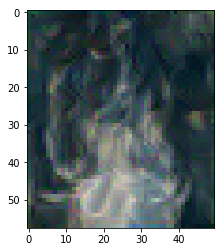

run [20]:
Style Loss: 14133.316406 Content Loss: 15.451712
Total Loss: 14148.768555

Step 1 -------
run [40]:
Style Loss: 3620.706787 Content Loss: 17.967897
Total Loss: 3638.674805

Step 2 -------
run [60]:
Style Loss: 1888.524902 Content Loss: 18.484221
Total Loss: 1907.009155

Step 3 -------
run [80]:
Style Loss: 1342.832031 Content Loss: 18.741579
Total Loss: 1361.573608

Step 4 -------
run [100]:
Style Loss: 1100.867188 Content Loss: 18.858913
Total Loss: 1119.726074

Step 5 -------
run [120]:
Style Loss: 966.484985 Content Loss: 18.825762
Total Loss: 985.310730

Step 6 -------
run [140]:
Style Loss: 875.570312 Content Loss: 18.964405
Total Loss: 894.534729

Step 7 -------
run [160]:
Style Loss: 814.038574 Content Loss: 19.027111
Total Loss: 833.065674

Step 8 -------
run [180]:
Style Loss: 768.796631 Content Loss: 19.001295
Total Loss: 787.797913

Step 9 -------
run [200]:
Style Loss: 735.724060 Content Loss: 19.036310
Total Loss: 754.760376

Step 10 -------
run [220]:
Style Loss

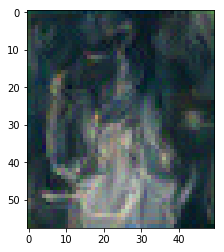

run [20]:
Style Loss: 1430612.500000 Content Loss: 15.411407
Total Loss: 1430627.875000

Step 1 -------
run [40]:
Style Loss: 369289.000000 Content Loss: 17.791485
Total Loss: 369306.781250

Step 2 -------
run [60]:
Style Loss: 190693.812500 Content Loss: 18.379366
Total Loss: 190712.187500

Step 3 -------
run [80]:
Style Loss: 134562.906250 Content Loss: 18.668140
Total Loss: 134581.578125

Step 4 -------
run [100]:
Style Loss: 107964.484375 Content Loss: 18.739265
Total Loss: 107983.226562

Step 5 -------
run [120]:
Style Loss: 93296.984375 Content Loss: 19.000431
Total Loss: 93315.984375

Step 6 -------
run [140]:
Style Loss: 84527.320312 Content Loss: 19.019781
Total Loss: 84546.343750

Step 7 -------
run [160]:
Style Loss: 78303.984375 Content Loss: 18.996216
Total Loss: 78322.984375

Step 8 -------
run [180]:
Style Loss: 73851.031250 Content Loss: 19.003010
Total Loss: 73870.031250

Step 9 -------
run [200]:
Style Loss: 70214.703125 Content Loss: 19.031752
Total Loss: 70233.73437

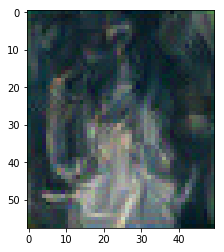

In [125]:
for style_level, style_content_ratio in tqdm(list(product(style_levels,style_content_ratios))):
    # Start from a fresh photo
    target = content.clone().requires_grad_(True).to(device)
           
    # for displaying the target image, intermittently
    show_every = 1
    style_weights = style_weights_dict[style_level]
    # iteration hyperparameters
    optimizer = optim.LBFGS([target], lr=0.2)
    steps = 20  # decide how many iterations to update your image (5000)
    run = [0]

    OUTPUT = Path('output')
    output_dir = f"{content_fn}_{'_'.join([fn for fn in style_fns])}"
    OUTPUT = OUTPUT/output_dir
    OUTPUT.mkdir(exist_ok=True)
    OUTPUT_SUBPATH = OUTPUT/f"{style_level}_{style_content_ratio}"
    OUTPUT_SUBPATH.mkdir(exist_ok=True)

    for ii in tqdm(range(1, steps+1)):

        def closure():
            # get the features from your target image
            target_features = get_features(target, vgg)

            # the content loss
            content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

            # initialize the style loss to 0
            style_loss = 0
            # then add to it for each layer's gram matrix loss
            for layer in style_weights:
                # get the "target" style representation for the layer
                target_feature = target_features[layer]
                target_gram = gram_matrix(target_feature)
                _, d, h, w = target_feature.shape
                for j, style_grams in enumerate(style_grams_ls):
                    # get the "style" style representation
                    style_gram = style_grams[layer]
                    # the style loss for one layer, weighted appropriately
                    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
                    # add to the style loss
                    style_loss += layer_style_loss / (d * h * w) * style_image_weights[j]

            # calculate the *total* loss
            style_loss =  style_loss * style_content_ratio            
            total_loss =  content_loss  + style_loss

            # update your target image
            optimizer.zero_grad()
            total_loss.backward()

            run[0] += 1
            if run[0] % 20 == 0:
                print("run {}:".format(run))
                print('Style Loss: {:4f}'.format(style_loss), 'Content Loss: {:4f}'.format(content_loss))
                print('Total Loss: {:4f}'.format(total_loss))
                print()
                print(f'Step {ii} -------')
            return total_loss
        
        # Save the first image
        plt.imsave(OUTPUT_SUBPATH/f"{ii}.jpg",im_convert(target))
        optimizer.step(closure)
              
    # Finish 1 set of parameter                  
    images = []
    for filename in OUTPUT_SUBPATH.glob('*.jpg'):
         images.append(imageio.imread(filename))
    
    imageio.mimsave(OUTPUT/f"{output_dir}_{style_level}_{style_content_ratio}.gif", images, fps=4) # Output gif
    plt.imsave(OUTPUT/f"{output_dir}_{style_level}_{style_level}_{style_content_ratio}.jpg",im_convert(target)) # Output the last image as well
    plt.imshow(im_convert(target))
    plt.show()


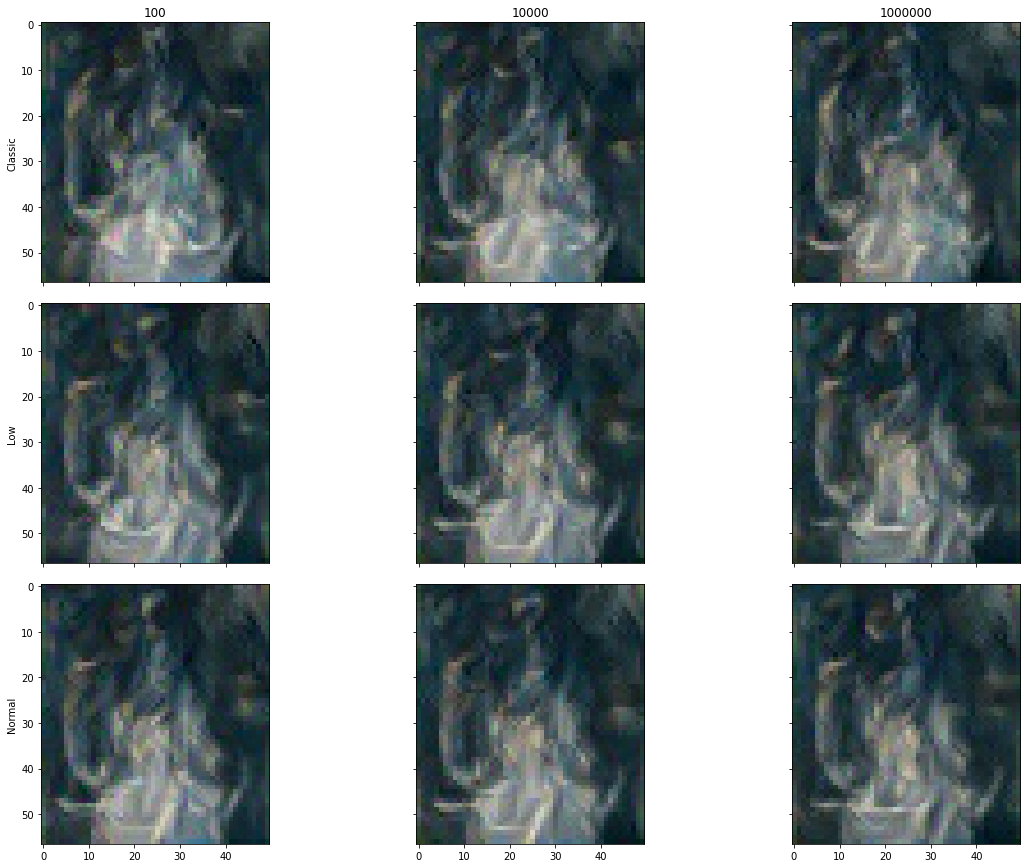

In [126]:
h,w = len(style_content_ratios), len(style_levels)
fig, axs = plt.subplots(h, w, figsize = (16,12), sharex=True, sharey=True)
plt.tight_layout()

imgs = []
styles = []
ratios = []
files = []
for file in OUTPUT.glob('*.jpg'):
    files.append(file)
    img = plt.imread(file)
    imgs.append(img)
    styles.append(file.parts[-1].split('_')[-2])
    ratios.append(file.parts[-1].split('_')[-1].split('.jpg')[0])

for i,ax in enumerate(axs):  
    for j, axe  in enumerate(ax):
        if i==0:
            axe.set_title(ratios[i*len(style_content_ratios) + j])
        if j==0:
            axe.set_ylabel(styles[i*len(style_content_ratios) + j])
        axe.imshow(imgs[j*len(style_content_ratios) + i])
    
plt.show()

In [116]:
fig.savefig(f"{output_dir}.jpg")